# Process ATOMIC and add inversed relations

In [71]:
tail_processed_relations = ['oEffect', 'oReact', 'oWant', 'xAttr', 
             'xIntent', 'xNeed', 'xReact', 'xWant', 'xEffect']
# isBefore, isAfter, HinderedBy, leave it alone.

# make ATOMIC tails complete sentences
import spacy

nlp = spacy.load("en_core_web_lg")

def contain_subject(sent):
    return any([tk.dep_ in ['nsubj', 'nsubjpass'] for tk in nlp(sent) ])
  
# def process_tail(tail, r):
#     if contain_subject(tail):
#         return tail
#     else:
#         if r in ['xEffect']:
#             return "PersonX " + tail
#         elif r in ['xNeed']:
#             initial_word = tail.split()[0]
#             if initial_word == "to":
#                 return "PersonX needs " + tail
#             elif initial_word in ["need", "needs"]:
#                 return "PersonX " + tail
#             else:
#                 return "PersonX needs to " + tail
#         elif r in ['xWant']:
#             initial_word = tail.split()[0]
#             if initial_word == "to":
#                 return "PersonX wants " + tail
#             elif initial_word in ["want", "wants"]:
#                 return "PersonX " + tail
#             else:
#                 return "PersonX wants to " + tail
#         elif r in ['xIntent']:
#             initial_word = tail.split()[0]
#             if initial_word == "to":
#                 return "PersonX " + " ".join(tail.split()[1:])
#             else:
#                 return "PersonX " + tail
#         elif r  in ['oEffect']:
#             return "PersonY " + tail
#         elif r in ['oWant']:
#             initial_word = tail.split()[0]
#             if initial_word == "to":
#                 return "PersonY wants " + tail
#             elif initial_word in ["want", "wants"]:
#                 return "PersonY " + tail
#             else:
#                 return "PersonY wants to " + tail
#         elif r == 'xReact':
#             return "PersonX feels " + tail
#         elif r == 'oReact':
#             return "PersonY feels " + tail
#         elif r == 'xAttr':
#             return "PersonX is " + tail

def process_tail(tail, r):
    # 1. if it's already a complete sentence (indicated by the initial PersonX/Y), 
    #    do nothing
    if tail.startswith("PersonX") or tail.startswith("PersonY") or \
        tail.startswith("they") or tail.lower().startswith("person"):
        return tail
    # 2. Deal with individual situations
    if r == "oEffect":
        if not contain_subject(tail):
            return "PersonY " + tail
        else:
            return tail
    elif r == "oReact":
        if not contain_subject(tail):
            return "PersonY feels " + tail
        else:
            return tail
    elif r == "oWant":
        initial = tail.split()[0]
        if initial.lower() == "to":
            return "PersonY wants " + tail
        elif initial.lower() in ["want", "wants"]:
            return "PersonY " + tail
        else:
            if not contain_subject(tail): # no subjects
                return "PersonY wants to " + tail
            else:
                return tail
    elif r == "xAttr":
        if not contain_subject(tail):
            return "PersonX is " + tail
        else:
            return tail
    elif r == "xIntent":
        initial = tail.split()[0]
        if initial.lower() == "to":
            return "PersonX " + " ".join(tail.split()[1:])
        else:
            if not contain_subject(tail):
                return "PersonX " + tail
            else:
                return tail
    elif r == "xNeed":
        initial = tail.split()[0]
        if initial.lower() == "to":
            return "PersonX needs " + tail
        elif initial.lower() in ["need", "needs"]:
            return "PersonX " + tail
        else:
            if not contain_subject(tail):
                return "PersonX needs to " + tail
            else:
                return tail
    elif r == "xReact":
        if not contain_subject(tail):
            return "PersonX feels " + tail
        else:
            return tail
    elif r == "xEffect":
        if not contain_subject(tail):
            return "PersonX " + tail
        else:
            return tail
    elif r == "xWant":
        initial = tail.split()[0]
        if initial.lower() == "to":
            return "PersonX wants " + tail
        elif initial.lower() in ["want", "wants"]:
            return "PersonX " + tail
        else:
            if not contain_subject(tail):
                return "PersonX wants to " + tail
            else:
                return tail
    

In [57]:
relation_tails = {r:[] for r in tail_processed_relations}

for i, (head, relation, tail) in tqdm(comet_datasets["train"][["head_event", "relation", "tail_event"]].iterrows()):
    if relation in relation_tails:
        relation_tails[relation].append(tail)

1076880it [01:19, 13532.93it/s]


In [61]:
from collections import Counter
for r in relation_tails:
    inital_cnter = Counter([tail.split()[0] for tail in relation_tails[r] if isinstance(tail, str)])
    print(r, sorted(inital_cnter.items(), key=lambda x:x[1], reverse=True)[:10])
    print()

oEffect [('none', 33428), ('gets', 2021), ('PersonY', 1775), ('they', 1384), ('is', 1223), ('Person', 966), ('smiles', 627), ('becomes', 612), ('has', 598), ('person', 424)]

oReact [('none', 25761), ('happy', 3475), ('grateful', 1784), ('thankful', 1081), ('sad', 750), ('angry', 688), ('loved', 597), ('like', 568), ('excited', 520), ('annoyed', 519)]

oWant [('to', 34285), ('none', 29518), ('To', 1271), ('thank', 484), ('get', 423), ('go', 329), ('talk', 248), ('ask', 222), ('PersonX', 187), ('say', 177)]

xAttr [('helpful', 2618), ('curious', 1948), ('friendly', 1879), ('caring', 1662), ('responsible', 1653), ('determined', 1501), ('kind', 1196), ('generous', 1163), ('smart', 1063), ('thoughtful', 978)]

xIntent [('to', 39891), ('none', 8419), ('a', 527), ('be', 359), ('the', 343), ('they', 274), ('get', 273), ('person', 227), ('wants', 204), ('help', 185)]

xNeed [('to', 52432), ('none', 13864), ('get', 2776), ('go', 1726), ('To', 1513), ('find', 1445), ('have', 1377), ('buy', 880),

# Process

In [78]:
import pandas as pd
from tqdm import tqdm
import numpy as np
comet_tsv_file = "/home/tfangaa/projects/comet-atomic-2020/data/kg/atomic2020_data-feb2021/{}.tsv"
comet_datasets = {
    "train": pd.read_csv(comet_tsv_file.format("train"), encoding='latin-1', sep="\t"),
    "dev": pd.read_csv(comet_tsv_file.format("dev"), encoding='latin-1', sep="\t"),
    "test": pd.read_csv(comet_tsv_file.format("test"), encoding='latin-1', sep="\t"),
}

for split in ["train", "dev", "test"]:
    reversed_edges = []
    reversed_edges_xy_reversed = []
    for i, (head, relation, tail) in tqdm(comet_datasets[split][["head_event", "relation", "tail_event"]].iterrows()):
        if tail == "none" or tail == "" or not isinstance(tail, str):
            continue
        # if relation in the original ATOMIC relations. Process tails with subjects
        if relation in tail_processed_relations:
            tail = process_tail(tail, relation)
        reversed_edges.append([tail, relation + " inversed", head])
        if relation in ["oEffect", "oReact", "oWant"]:
            head = head.replace("PersonX", "[PY]").replace("PersonY", "[PX]")\
                .replace("[PX]", "PersonX").replace("[PY]", "PersonY")
            tail = tail.replace("PersonX", "[PY]").replace("PersonY", "[PX]")\
                .replace("[PX]", "PersonX").replace("[PY]", "PersonY")
        reversed_edges_xy_reversed.append([tail, relation + " inversed", head])
    
    print(split, "reversed len:", len(reversed_edges), "original len:", len(comet_datasets[split]))
    # inversed augmented version
    comet_datasets[split].append(
        pd.DataFrame(reversed_edges, columns=["head_event", "relation", "tail_event"],
                    index=range(len(comet_datasets[split]), 
                                len(comet_datasets[split]) + len(reversed_edges)))
    ).to_csv(comet_tsv_file.format(split + "_inversed"), index=False, encoding='latin-1', sep="\t")
    # inversed augmented with PersonY PersonX replaced (for o-relations)
    comet_datasets[split].append(
        pd.DataFrame(reversed_edges_xy_reversed, columns=["head_event", "relation", "tail_event"],
                    index=range(len(comet_datasets[split]), 
                                len(comet_datasets[split]) + len(reversed_edges)))
    ).to_csv(comet_tsv_file.format(split + "_inversed_xy_reversed"), index=False, encoding='latin-1', sep="\t")

1076880it [30:20, 591.50it/s]  


train reversed len: 957050 original len: 1076880


102024it [03:10, 535.67it/s]  


dev reversed len: 88914 original len: 102024


152209it [03:43, 680.89it/s]  


test reversed len: 137360 original len: 152209


In [ ]:
import numpy as np
reversed_edges_xy_reversed_triple = [" | ".join((h, r, t)) for h, r, t in reversed_edges_xy_reversed]
np.random.choice(reversed_edges_xy_reversed_triple, 100)
# "to see y work xNeed inversed PersonX loves PersonY's work",
# 'PersonX PersonX reaches past it xEffect inversed PersonX reaches around PersonY',
# 

# Check sentence lengths

In [79]:
CS_RELATIONS_2NL = {
    "AtLocation": "located or found at or in or on",
    "CapableOf": "is or are capable of",
    "Causes" : "causes",
    "CausesDesire": "makes someone want",
    "CreatedBy": " is created by",
    "Desires": "desires",
    "HasA": "has, possesses, or contains",
    "HasFirstSubevent": "begins with the event or action",
    "HasLastSubevent": "ends with the event or action",
    "HasPrerequisite": "to do this, one requires",
    "HasProperty": "can be characterized by being or having",
    "HasSubEvent" : "includes the event or action",
    "HinderedBy" : "can be hindered by",
    "InstanceOf" : " is an example or instance of",
    "isAfter" : "happens after",
    "isBefore" : "happens before",
    "isFilledBy" : "blank can be filled by",
    "MadeOf": "is made of",
    "MadeUpOf": "made up of",
    "MotivatedByGoal": "is a step towards accomplishing the goal",
    "NotDesires": "do not desire",
    "ObjectUse": "used for",
    "UsedFor": "used for",
    "oEffect" : "as a result, PersonY or others will",
    "oReact" : "as a result, PersonY or others feel",
    "oWant" : "as a result, PersonY or others want to",
    "PartOf" : "is a part of",
    "ReceivesAction" : "can receive or be affected by the action",
    "xAttr" : "PersonX is seen as",
    "xEffect" : "as a result, PersonX will",
    "xReact" : "as a result, PersonX feels",
    "xWant" : "as a result, PersonX wants to",
    "xNeed" : "but before, PersonX needed",
    "xIntent" : "because PersonX wanted",
    "xReason" : "because",
    "general Effect" : "as a result, other people or things will",
    "general Want" : "as a result, other people or things want to",
    "general React" : "as a result, other people or things feel",
    # inversed
    "AtLocation inversed": "can find or include", # "located or found at or in or on"
    "CapableOf inversed": "is a skill of", # "is or are capable of"
    "Causes inversed" : "is the reason of", # causes
    "CausesDesire inversed": "want", # "makes someone want",
    "CreatedBy inversed": "create", # "is created by",
    "Desires inversed": "is desired by", # "desires",
    "HasA inversed": "is possessed by",# "has, possesses, or contains",
    "HasFirstSubevent inversed": "is the beginning of", # "begins with the event or action",
    "HasLastSubevent inversed": "is the end of", # "ends with the event or action",
    "HasPrerequisite inversed": "is the prerequisite of",# "to do this, one requires",
    "HasProperty inversed": "is the property of", # "can be characterized by being or having",
    "HasSubEvent inversed" : "is included by",# "includes the event or action",
    "HinderedBy inversed" : "hinder", #"can be hindered by",
    "InstanceOf inversed" : "include", #" is an example or instance of", not sure about this.
    "isAfter inversed" : "happens before", # "happens after",
    "isBefore inversed" : "happens after", # "happens before",
    "isFilledBy inversed" : "can fill",# "blank can be filled by",
    "MadeOf inversed": "make up of", # "is made of", 
    "MadeUpOf inversed": "is made of", # "made up of",
    "MotivatedByGoal inversed": "motivate", # "is a step towards accomplishing the goal",
    "NotDesires inversed": "is not desired by", # "do not desire",
    "ObjectUse inversed": "could make use of", # "used for",
    "UsedFor inversed": "could make use of", # "used for",
    "oEffect inversed" : "because", #"as a result, PersonY or others will",
    "oReact inversed" : "because", #"as a result, PersonY or others feel",
    "oWant inversed" : "because", # "as a result, PersonY or others want to",
    "PartOf inversed" : "include", # "is a part of",
    "ReceivesAction inversed" : "affect", # "can receive or be affected by the action",
    "xAttr inversed" : "", # "PersonX is seen as",
    "xEffect inversed" : "because", # "as a result, PersonX will",
    "xReact inversed" : "because", # "as a result, PersonX feels",
    "xWant inversed" : "because",# "as a result, PersonX wants to",
    "xNeed inversed" : "as a result, ",# "but before, PersonX needed",
    "xIntent inversed" : "as a result, ", # "because PersonX wanted",
    "xReason inversed" : "as a result, ",# "because",
    "general Effect inversed" : "because", # "as a result, other people or things will",
    "general Want inversed" : "because", # "as a result, other people or things want to",
    "general React inversed" : "because", # "as a result, other people or things feel",
}

In [81]:
comet_tsv_file = "/home/tfangaa/projects/comet-atomic-2020/data/kg/atomic2020_data-feb2021/{}_inversed.tsv"
comet_datasets = {
    "train": pd.read_csv(comet_tsv_file.format("train"), encoding='latin-1', sep="\t"),
}

split = "train"

sent_lenghts = []

for i, (head, relation, tail) in tqdm(comet_datasets[split][["head_event", "relation", "tail_event"]].iterrows()):
    sent_lenghts.append( len(head.split()) + len(CS_RELATIONS_2NL[relation].split()) + len(str(tail).split()) )

2033930it [02:34, 13198.42it/s]


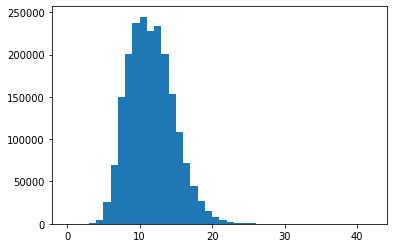

In [83]:
from matplotlib import pyplot as plt

plt.hist(sent_lenghts, bins=range(max(sent_lenghts)))

plt.show()